In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from util import get_normalized_data
from sklearn.utils import shuffle

In [17]:
class HiddenLayer(object):
    def __init__(self, M1, M2):
        self.M1 = M1
        self.M2 = M2
        W = np.random.randn(M1, M2) / np.sqrt(M1 + M2)
        b = np.zeros(M2)
        self.W = tf.Variable(W.astype(np.float32))
        self.b = tf.Variable(b.astype(np.float32))
        self.params = [self.W, self.b]
        
    def forward(self, X):
        return tf.nn.relu(tf.matmul(X, self.W) + self.b)
    
class ANN(object):
    def __init__(self, hidden_layer_sizes, p_keep):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.dropout_rates = p_keep
    
    def fit(self, X, Y, lr=10e-7, mu=0.99, decay=0.999, epochs=300, batch_sz=100):
        # Make a validation set
        X, Y = shuffle(X, Y)
        X = X.astype(np.float32)
        Y = Y.astype(np.int64)
        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        X, Y = X[:-1000], Y[:-1000]
        
        # initialize hidden layers
        N, D = X.shape
        K = len(set(Y))
        self.hidden_layers = []
        M1 = D
        for M2 in self.hidden_layer_sizes:
            h = HiddenLayer(M1, M2)
            self.hidden_layers.append(h)
            M1 = M2
        W = np.random.randn(M1, K) / np.sqrt(M1 + K)
        b = np.zeros(K)
        self.W = tf.Variable(W.astype(np.float32))
        self.b = tf.Variable(b.astype(np.float32))
        
        # collect params for later use
        self.params = [self.W, self.b]
        for h in self.hidden_layers:
            self.params += h.params
        
        # Set up functions and variables
        inputs = tf.placeholder(tf.float32, shape=(None, D), name='inputs')
        labels = tf.placeholder(tf.int64, shape=(None,), name='labels')
        logits = self.forward(inputs) # define this below
        
        cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels))
        train_op = tf.train.RMSPropOptimizer(lr, decay=decay, momentum=mu).minimize(cost)
        prediction = self.predict(inputs) # define below
        
        n_batches = N//batch_sz
        costs = []
        init = tf.global_variables_initializer()
        with tf.Session() as session:
            session.run(init)
            for i in range(epochs):
                X, Y = shuffle(X, Y)
                for j in range(n_batches):
                    Xbatch = X[j*batch_sz:(j*batch_sz + batch_sz)]
                    Ybatch = Y[j*batch_sz:(j*batch_sz + batch_sz)]
                    
                    session.run(train_op, feed_dict={inputs: Xbatch, labels: Ybatch})
                    
                    if j % 20 == 0:
                        c = session.run(cost, feed_dict={inputs: Xvalid, labels: Yvalid})
                    p = session.run(prediction, feed_dict={inputs: Xvalid})
                        costs.append(c)
                        e = error_rate(Yvalid, p)
                        print("I:", i, "j:", j, "nb:", n_batches, "cost:", c, "error rate:", e)
        plt.plot(costs)
        
    def forward(self, X):
        # no need to define different functions for train and predict
        # tf.nn.dropout takes cae of the differences for us
        Z = X
        Z = tf.nn.dropout(Z, self.dropout_rates[0])
        for h, p in zip(self.hidden_layers, self.dropout_rates[1:]):
            Z = h.forward(Z)
            Z = tf.nn.dropout(Z, p)
        return tf.matmul(Z, self.W) + self.b
    
    def predict(self, X):
        pY = self.forward(X)
        return tf.argmax(pY, 1)
    
    
def error_rate(p, t):
    return np.mean(p != t)

def relu(a):
    return a * (a > 0)
        

In [5]:
X, Y = get_normalized_data()

Reading in and transforming data...


I: 0 j: 0 nb: 410 cost: 2.46537 error rate: 0.897
I: 0 j: 20 nb: 410 cost: 2.37853 error rate: 0.868
I: 0 j: 40 nb: 410 cost: 2.18948 error rate: 0.772
I: 0 j: 60 nb: 410 cost: 1.9654 error rate: 0.588
I: 0 j: 80 nb: 410 cost: 1.6947 error rate: 0.488
I: 0 j: 100 nb: 410 cost: 1.47736 error rate: 0.421
I: 0 j: 120 nb: 410 cost: 1.20806 error rate: 0.336
I: 0 j: 140 nb: 410 cost: 1.05685 error rate: 0.309
I: 0 j: 160 nb: 410 cost: 0.91332 error rate: 0.291
I: 0 j: 180 nb: 410 cost: 0.790022 error rate: 0.234
I: 0 j: 200 nb: 410 cost: 0.738162 error rate: 0.234
I: 0 j: 220 nb: 410 cost: 0.741937 error rate: 0.224
I: 0 j: 240 nb: 410 cost: 0.656496 error rate: 0.222
I: 0 j: 260 nb: 410 cost: 0.669905 error rate: 0.191
I: 0 j: 280 nb: 410 cost: 0.608381 error rate: 0.176
I: 0 j: 300 nb: 410 cost: 0.637044 error rate: 0.173
I: 0 j: 320 nb: 410 cost: 0.574367 error rate: 0.154
I: 0 j: 340 nb: 410 cost: 0.557694 error rate: 0.157
I: 0 j: 360 nb: 410 cost: 0.540171 error rate: 0.146
I: 0 j: 38

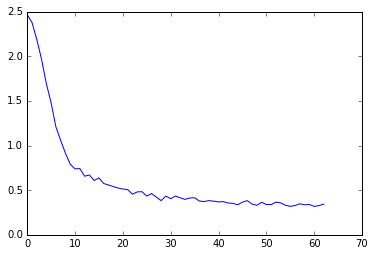

In [20]:
ann = ANN([500, 300], [0.8, 0.5, 0.5])
ann.fit(X, Y, epochs=3, lr=50e-5, mu=0.99, decay=0.9999)

### Again

In [37]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from util import get_normalized_data
from sklearn.utils import shuffle

In [46]:
X, Y= get_normalized_data()

Reading in and transforming data...


In [67]:
class HiddenLayer(object):
    def __init__(self, M1, M2):
        self.M1 = M1
        self.M2 = M2
        W = np.random.randn(M1, M2) / np.sqrt(M1 + M2)
        b = np.zeros(M2)
        self.W = tf.Variable(W.astype(np.float32))
        self.b = tf.Variable(b.astype(np.float32))
        self.params = [self.W, self.b]
        
    def forward(self, X):
        return tf.nn.relu(tf.matmul(X, self.W) + self.b)
    
class ANN(object):
    def __init__(self, hidden_layer_sizes, p_keep):
        self.hidden_layer_sizes = hidden_layer_sizes
        self.dropout_rates = p_keep
        
    def fit(self, X, Y, lr=10e-7, mu=0.99, decay=0.999, epochs=300, batch_sz=100):
        # Make a validation set
        X, Y = shuffle(X, Y)
        X = X.astype(np.float32)
        Y = Y.astype(np.int64)
        Xvalid, Yvalid = X[-1000:], Y[-1000:]
        X, Y = X[:-1000], Y[:-1000]
        
        # initialize hidden layers
        N, D = X.shape
        K = len(set(Y))
        self.hidden_layers = []
        M1 = D
        for M2 in self.hidden_layer_sizes:
            h = HiddenLayer(M1, M2)
            self.hidden_layers.append(h)
            M1 = M2
        W = np.random.randn(M1, K) / np.sqrt(M1 + K)
        b = np.zeros(K)
        self.W = tf.Variable(W.astype(np.float32))
        self.b = tf.Variable(b.astype(np.float32))
        
        # collect params for later use
        self.params = [self.W, self.b]
        for h in self.hidden_layers:
            self.params += h.params
            
        # Set up functions and variables
        inputs = tf.placeholder(tf.float32, shape=(None, D), name='inputs')
        labels = tf.placeholder(tf.int64, shape=(None,), name='labels')
        logits = self.forward(inputs)
        
        cost = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits, labels))
        train_op = tf.train.RMSPropOptimizer(lr, decay=decay, momentum=mu).minimize(cost)
        prediction = self.predict(inputs)
        
        n_batches = N // batch_sz
        costs = []
        init = tf.global_variables_initializer()
        with tf.Session() as session:
            session.run(init)
            for i in range(epochs):
                X, Y = shuffle(X, Y)
                for j in range(n_batches):
                    Xbatch = X[j*batch_sz:(j*batch_sz+batch_sz)]
                    Ybatch = Y[j*batch_sz:(j*batch_sz+batch_sz)]
                    
                    session.run(train_op, feed_dict={inputs: Xbatch, labels: Ybatch})
                    
                    if j % 20 == 0:
                        c = session.run(cost, feed_dict={inputs: Xvalid, labels: Yvalid})
                        p = session.run(prediction, feed_dict={inputs: Xvalid})
                        costs.append(c)
                        e = error_rate(Yvalid, p)
                        print("i:", i, "j:", j, "nb:", n_batches, "cost:", c, "error rate:", e)
        plt.plot(costs)
        
    def forward(self, X):
        # no need to define different functions for train and predict
        # tf.nn.dropout takes care of the differences for us
        Z = X
        Z = tf.nn.dropout(Z, self.dropout_rates[0])
        for h, p in zip(self.hidden_layers, self.dropout_rates[1:]):
            Z = h.forward(Z)
            Z = tf.nn.dropout(Z, p)
        return tf.matmul(Z, self.W) + self.b
    
    def predict(self, X):
        pY = self.forward(X)
        return tf.argmax(pY, 1)
    

def error_rate(p, t):
    return np.mean(p != t)

def relu(a):
    return a * (a > 0)


i: 0 j: 0 nb: 410 cost: 2.42415 error rate: 0.885
i: 0 j: 20 nb: 410 cost: 2.2315 error rate: 0.82
i: 0 j: 40 nb: 410 cost: 1.89259 error rate: 0.577
i: 0 j: 60 nb: 410 cost: 1.46542 error rate: 0.409
i: 0 j: 80 nb: 410 cost: 1.11346 error rate: 0.311
i: 0 j: 100 nb: 410 cost: 0.884763 error rate: 0.278
i: 0 j: 120 nb: 410 cost: 0.729267 error rate: 0.233
i: 0 j: 140 nb: 410 cost: 0.753207 error rate: 0.218
i: 0 j: 160 nb: 410 cost: 0.640591 error rate: 0.208
i: 0 j: 180 nb: 410 cost: 0.613216 error rate: 0.169
i: 0 j: 200 nb: 410 cost: 0.527146 error rate: 0.175
i: 0 j: 220 nb: 410 cost: 0.542825 error rate: 0.15
i: 0 j: 240 nb: 410 cost: 0.506788 error rate: 0.13
i: 0 j: 260 nb: 410 cost: 0.487386 error rate: 0.127
i: 0 j: 280 nb: 410 cost: 0.436766 error rate: 0.145
i: 0 j: 300 nb: 410 cost: 0.450633 error rate: 0.129
i: 0 j: 320 nb: 410 cost: 0.406126 error rate: 0.127
i: 0 j: 340 nb: 410 cost: 0.402425 error rate: 0.12
i: 0 j: 360 nb: 410 cost: 0.414929 error rate: 0.124
i: 0 j: 3

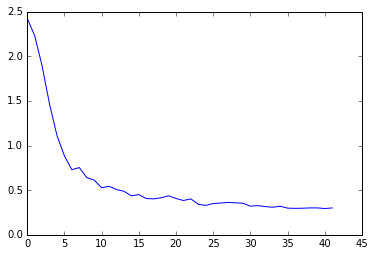

In [68]:
ann = ANN([500, 300], [0.8, 0.5, 0.5])
ann.fit(X, Y, epochs=2, lr=10e-4, mu=0.99, decay=0.9999)